In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *

%matplotlib inline

**L'idée est d'explorer la survenue des spindle sur la respi, sur les cycles respi non stretchés, et donc de vraiment explorer quand se situent préférentiellement les spindle par rapport à des évènements respiratoires particuliers tels que la transition i vers e ou e vers i**

**Il faut donc découper les TF autour de ces évènements particuliers, avec une fenêtre qui entoure ces évènements .. à définir**

**Il faut donc :**
- Charger les rsp_features pour avoir les moments des transitions
- Charger les TF
- Fenêtrer les TF autour des transitions

In [3]:
mode = 'load'

In [4]:
participants = patients

In [5]:
srate = 128

## DATA LOADING

In [6]:
def load_rsp(participants=participants):
    concat = []
    for participant in participants:
        rsp = pd.read_excel(f'../df_analyse/resp_features_encoded_{participant}.xlsx', index_col = 0).loc[:,['participant', 'inspi_index','expi_index', 'inspi_time','expi_time', 'cycle_duration','insp_duration','exp_duration','event']]
        concat.append(rsp)
    df_return = pd.concat(concat)
    return df_return

In [7]:
rsp = load_rsp()

In [8]:
rsp

,participant,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,event
0,P1,155,434,0.605469,1.695312,2.960938,1.089844,1.871094,0
1,P1,913,1202,3.566406,4.695312,3.140625,1.128906,2.011719,0
2,P1,1717,1996,6.707031,7.796875,3.136719,1.089844,2.046875,0
3,P1,2520,2795,9.843750,10.917969,3.140625,1.074219,2.066406,0
4,P1,3324,3557,12.984375,13.894531,2.535156,0.910156,1.625000,0
...,...,...,...,...,...,...,...,...,...
3302,P10,3351173,3351466,13090.519531,13091.664062,3.199219,1.144531,2.054688,0
3303,P10,3351992,3352298,13093.718750,13094.914062,3.359375,1.195312,2.164062,0
3304,P10,3352852,3353141,13097.078125,13098.207031,3.226562,1.128906,2.097656,0
3305,P10,3353678,3353963,13100.304688,13101.417969,3.203125,1.113281,2.089844,0


In [9]:
rsp_spindled = rsp[rsp['event'] == 1]

In [10]:
rsp_spindled

,participant,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,event
15,P1,11601,11880,45.316406,46.406250,2.644531,1.089844,1.554688,1
19,P1,14621,14918,57.113281,58.273438,3.117188,1.160156,1.957031,1
20,P1,15419,15690,60.230469,61.289062,3.003906,1.058594,1.945312,1
21,P1,16188,16481,63.234375,64.378906,3.093750,1.144531,1.949219,1
22,P1,16980,17236,66.328125,67.328125,2.875000,1.000000,1.875000,1
...,...,...,...,...,...,...,...,...,...
3173,P10,3244376,3244684,12673.343750,12674.546875,3.464844,1.203125,2.261719,1
3186,P10,3255346,3255668,12716.195312,12717.453125,3.144531,1.257812,1.886719,1
3193,P10,3261254,3261551,12739.273438,12740.433594,3.289062,1.160156,2.128906,1
3259,P10,3315748,3316051,12952.140625,12953.324219,2.867188,1.183594,1.683594,1


In [11]:
half_window_size = round(rsp_spindled['exp_duration'].quantile(0.75), 1) # les fenetres comprendront la majorité du cycle respi
half_wsize_points = int(half_window_size * srate)

In [12]:
half_wsize_points

371

In [13]:
half_window_size

2.9

In [14]:
df_rows = []
for cycle , row in rsp.iterrows():
    if cycle != 0:
        participant = row['participant']

        slice_point_ie = row['inspi_index'] // 2
        slice_point_ei = row['expi_index'] // 2

        start_ie = slice_point_ie - half_wsize_points
        stop_ie = slice_point_ie + half_wsize_points

        start_ei = slice_point_ei - half_wsize_points
        stop_ei = slice_point_ei + half_wsize_points

        # if start_ei < 0:
        #     continue
        # if stop_ei < 0:
        #     continue

        wsize_ie = stop_ie - start_ie
        wsize_ei = stop_ei - start_ei

        df_row = [participant, cycle, start_ei, stop_ei, wsize_ei, start_ie, stop_ie, wsize_ie]
        df_rows.append(df_row)
df_slices = pd.DataFrame(df_rows, columns = ['participant','cycle','start ei','stop ei','wsize ei','start ie','stop ie','wsize ie'])
    

In [15]:
df_slices

,participant,cycle,start ei,stop ei,wsize ei,start ie,stop ie,wsize ie
0,P1,1,230,972,742,85,827,742
1,P1,2,627,1369,742,487,1229,742
2,P1,3,1026,1768,742,889,1631,742
3,P1,4,1407,2149,742,1291,2033,742
4,P1,5,1750,2492,742,1615,2357,742
...,...,...,...,...,...,...,...,...
32416,P10,3302,1675362,1676104,742,1675215,1675957,742
32417,P10,3303,1675778,1676520,742,1675625,1676367,742
32418,P10,3304,1676199,1676941,742,1676055,1676797,742
32419,P10,3305,1676610,1677352,742,1676468,1677210,742


In [16]:
def load_tf(participants=participants):
    concat = []
    for participant in participants:
        print(participant)
        tf = xr.load_dataarray(f'../dataarray/da_tf_frontal_{participant}.nc').astype('float32')
        concat.append(tf)
    da_return = xr.concat(concat, dim = 'participant')
    da_return = da_return.assign_coords({'participant':participants})
    return da_return

In [17]:
if mode == 'save':
    da = load_tf()
    da.to_netcdf(f'../dataarray/da_tf_frontal_all.nc')
elif mode == 'load':
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_all.nc')

In [18]:
da

<xarray.DataArray (participant: 9, freqs: 40, time: 2376960)>
array([[[2.50612715e+04, 2.55806035e+04, 2.58901387e+04, ...,
                    nan,            nan,            nan],
        [2.35207695e+04, 2.39984922e+04, 2.42807246e+04, ...,
                    nan,            nan,            nan],
        [2.18913770e+04, 2.23071855e+04, 2.25397344e+04, ...,
                    nan,            nan,            nan],
        ...,
        [4.60722998e+03, 4.57116602e+03, 4.48800195e+03, ...,
                    nan,            nan,            nan],
        [4.59891699e+03, 4.56972363e+03, 4.49369873e+03, ...,
                    nan,            nan,            nan],
        [4.60669385e+03, 4.58544922e+03, 4.51751074e+03, ...,
                    nan,            nan,            nan]],

       [[1.05402227e+05, 1.05095344e+05, 1.03736156e+05, ...,
         3.04025273e+04, 3.17456055e+04, 3.27889141e+04],
        [1.01430883e+05, 1.01246992e+05, 1.00058617e+05, ...,
         2.80542637e+04, 2.93148750e+04, 3.03057793e+04],
        [9.77243281e+04, 9.76418516e+04, 9.65971797e+04, ...,
         2.60406484e+04, 2.72258887e+04, 2.81672207e+04],
...
        [1.00372432e+04, 1.01470283e+04, 1.01575586e+04, ...,
                    nan,            nan,            nan],
        [9.48030078e+03, 9.55114746e+03, 9.52434375e+03, ...,
                    nan,            nan,            nan],
        [8.97213672e+03, 9.01438867e+03, 8.96178418e+03, ...,
                    nan,            nan,            nan]],

       [[2.83997631e+01, 1.88306541e+01, 1.20238256e+01, ...,
                    nan,            nan,            nan],
        [1.99086361e+01, 1.07523022e+01, 4.23592281e+00, ...,
                    nan,            nan,            nan],
        [3.22466812e+01, 2.43530388e+01, 1.87970963e+01, ...,
                    nan,            nan,            nan],
        ...,
        [4.65298126e+02, 4.59088562e+02, 4.46789612e+02, ...,
                    nan,            nan,            nan],
        [4.46182343e+02, 4.41412689e+02, 4.31113800e+02, ...,
                    nan,            nan,            nan],
        [4.35286591e+02, 4.32824554e+02, 4.25382050e+02, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * time         (time) float64 0.0 0.007812 0.01562 ... 1.857e+04 1.857e+04
  * freqs        (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * participant  (participant) object 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P9' 'P10'

In [19]:
n_cycles_to_compute = {}
for participant in participants:
    n_cycles_to_compute[participant] = rsp[(rsp['participant'] == participant) & (rsp['event'] == 1)].reset_index(drop=True).shape[0]
min_n_cycles_to_compute = min(n_cycles_to_compute.values())

In [20]:
min_n_cycles_to_compute

430

In [21]:
wsize_in_points = df_slices['wsize ei'].unique()[0]
da_erp = None

for participant_idx, participant in enumerate(participants):
    print(participant)

    slices_participant = df_slices[(df_slices['participant'] == participant)].reset_index(drop = True)

    da_participant = da.sel(participant = participant).dropna(dim = 'time')
    
    for transition_idx, transition in enumerate(['i-e','e-i']):
        
        if transition == 'i-e':
            timings = slices_participant.loc[:,['start ie','stop ie']]
        elif transition == 'e-i':
            timings = slices_participant.loc[:,['start ei','stop ei']]
        
        for cycle, timing in timings.iterrows():
            if cycle == min_n_cycles_to_compute:
                break
            
            if transition == 'i-e':
                start = timing['start ie']
                stop = timing['stop ie']
                
            elif transition == 'e-i':
                start = timing['start ei']
                stop = timing['stop ei']
            
            tf_sliced = da_participant[  : , start:stop].values

            if da_erp is None:
                da_erp = gh.init_da({'normalisation':['raw','normal'], 'participant':participants, 'cycle':np.arange(0,min_n_cycles_to_compute,1), 'transition':['i-e','e-i'] , 'freqs':da.coords['freqs'] , 'time':np.arange(0, wsize_in_points, 1)})
            
            da_erp[0, participant_idx, cycle , transition_idx  , : , :] = tf_sliced
    erp_participant = da_erp.loc['raw',participant,:,:,:,:].values
    da_erp.loc['normal',participant,:,:,:,:] = (erp_participant - np.mean(erp_participant)) / np.std(erp_participant)

P1
P2
P3
P4
P5
P6
P7
P9
P10


In [22]:
da_erp

<xarray.DataArray (normalisation: 2, participant: 9, cycle: 430, transition: 2, freqs: 40, time: 742)>
array([[[[[[ 2.57630646e+02,  2.02332458e+02,  1.49741943e+02, ...,
             2.69263691e+04,  2.74869980e+04,  2.79778145e+04],
           [ 4.28654297e+02,  3.66325409e+02,  3.09392548e+02, ...,
             2.52865059e+04,  2.58281406e+04,  2.63170430e+04],
           [ 7.44008057e+02,  6.86232239e+02,  6.36752747e+02, ...,
             2.26470430e+04,  2.31219805e+04,  2.35601523e+04],
           ...,
           [ 9.78211365e+02,  9.97500732e+02,  1.01566370e+03, ...,
             1.42052658e+02,  1.55086990e+02,  1.69384186e+02],
           [ 7.48993103e+02,  7.68297852e+02,  7.85921875e+02, ...,
             1.06822144e+02,  1.27883308e+02,  1.51862762e+02],
           [ 5.46646912e+02,  5.65417358e+02,  5.81758667e+02, ...,
             7.76322250e+01,  1.05723946e+02,  1.38640869e+02]],

          [[ 6.44273911e+01,  4.58890877e+01,  3.12642746e+01, ...,
             6.32763123e+02,  5.97388184e+02,  5.57580322e+02],
           [ 3.74742966e+01,  2.54913578e+01,  1.65398350e+01, ...,
             7.59537354e+02,  7.11601624e+02,  6.60771484e+02],
           [ 2.49248428e+01,  1.72815628e+01,  1.21628418e+01, ...,
             8.86820374e+02,  8.41974304e+02,  7.95153748e+02],
...
           [-4.18625877e-01, -4.18864965e-01, -4.18804384e-01, ...,
            -4.00943647e-01, -3.98996027e-01, -3.96893441e-01],
           [-4.22272127e-01, -4.22493699e-01, -4.22401428e-01, ...,
            -4.02986331e-01, -4.01734194e-01, -4.00296312e-01],
           [-4.24113538e-01, -4.24300329e-01, -4.24171824e-01, ...,
            -4.06739288e-01, -4.06020629e-01, -4.05078885e-01]],

          [[ 8.00146930e-02,  9.15808803e-02,  1.01866103e-01, ...,
            -1.12050822e-01, -1.23048371e-01, -1.37393099e-01],
           [ 1.18736473e-01,  1.26694520e-01,  1.33181477e-01, ...,
            -1.30576672e-01, -1.38462979e-01, -1.50299791e-01],
           [ 1.34662717e-01,  1.38022478e-01,  1.39557209e-01, ...,
            -1.38855882e-01, -1.43849799e-01, -1.53116774e-01],
           ...,
           [-4.20125547e-01, -4.20049599e-01, -4.19734662e-01, ...,
            -3.98982015e-01, -4.01724196e-01, -4.04372530e-01],
           [-4.22702389e-01, -4.22855804e-01, -4.22733796e-01, ...,
            -3.92122867e-01, -3.95231294e-01, -3.98260462e-01],
           [-4.24078379e-01, -4.24336768e-01, -4.24288326e-01, ...,
            -3.83978550e-01, -3.87262530e-01, -3.90482821e-01]]]]]])
Coordinates:
  * normalisation  (normalisation) <U6 'raw' 'normal'
  * participant    (participant) <U3 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P9' 'P10'
  * cycle          (cycle) int64 0 1 2 3 4 5 6 7 ... 423 424 425 426 427 428 429
  * transition     (transition) <U3 'i-e' 'e-i'
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * time           (time) int64 0 1 2 3 4 5 6 7 ... 735 736 737 738 739 740 741

In [23]:
da_erp = da_erp.assign_coords({'time':da_erp.coords['time']/srate})

In [24]:
da_erp

<xarray.DataArray (normalisation: 2, participant: 9, cycle: 430, transition: 2, freqs: 40, time: 742)>
array([[[[[[ 2.57630646e+02,  2.02332458e+02,  1.49741943e+02, ...,
             2.69263691e+04,  2.74869980e+04,  2.79778145e+04],
           [ 4.28654297e+02,  3.66325409e+02,  3.09392548e+02, ...,
             2.52865059e+04,  2.58281406e+04,  2.63170430e+04],
           [ 7.44008057e+02,  6.86232239e+02,  6.36752747e+02, ...,
             2.26470430e+04,  2.31219805e+04,  2.35601523e+04],
           ...,
           [ 9.78211365e+02,  9.97500732e+02,  1.01566370e+03, ...,
             1.42052658e+02,  1.55086990e+02,  1.69384186e+02],
           [ 7.48993103e+02,  7.68297852e+02,  7.85921875e+02, ...,
             1.06822144e+02,  1.27883308e+02,  1.51862762e+02],
           [ 5.46646912e+02,  5.65417358e+02,  5.81758667e+02, ...,
             7.76322250e+01,  1.05723946e+02,  1.38640869e+02]],

          [[ 6.44273911e+01,  4.58890877e+01,  3.12642746e+01, ...,
             6.32763123e+02,  5.97388184e+02,  5.57580322e+02],
           [ 3.74742966e+01,  2.54913578e+01,  1.65398350e+01, ...,
             7.59537354e+02,  7.11601624e+02,  6.60771484e+02],
           [ 2.49248428e+01,  1.72815628e+01,  1.21628418e+01, ...,
             8.86820374e+02,  8.41974304e+02,  7.95153748e+02],
...
           [-4.18625877e-01, -4.18864965e-01, -4.18804384e-01, ...,
            -4.00943647e-01, -3.98996027e-01, -3.96893441e-01],
           [-4.22272127e-01, -4.22493699e-01, -4.22401428e-01, ...,
            -4.02986331e-01, -4.01734194e-01, -4.00296312e-01],
           [-4.24113538e-01, -4.24300329e-01, -4.24171824e-01, ...,
            -4.06739288e-01, -4.06020629e-01, -4.05078885e-01]],

          [[ 8.00146930e-02,  9.15808803e-02,  1.01866103e-01, ...,
            -1.12050822e-01, -1.23048371e-01, -1.37393099e-01],
           [ 1.18736473e-01,  1.26694520e-01,  1.33181477e-01, ...,
            -1.30576672e-01, -1.38462979e-01, -1.50299791e-01],
           [ 1.34662717e-01,  1.38022478e-01,  1.39557209e-01, ...,
            -1.38855882e-01, -1.43849799e-01, -1.53116774e-01],
           ...,
           [-4.20125547e-01, -4.20049599e-01, -4.19734662e-01, ...,
            -3.98982015e-01, -4.01724196e-01, -4.04372530e-01],
           [-4.22702389e-01, -4.22855804e-01, -4.22733796e-01, ...,
            -3.92122867e-01, -3.95231294e-01, -3.98260462e-01],
           [-4.24078379e-01, -4.24336768e-01, -4.24288326e-01, ...,
            -3.83978550e-01, -3.87262530e-01, -3.90482821e-01]]]]]])
Coordinates:
  * normalisation  (normalisation) <U6 'raw' 'normal'
  * participant    (participant) <U3 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P9' 'P10'
  * cycle          (cycle) int64 0 1 2 3 4 5 6 7 ... 423 424 425 426 427 428 429
  * transition     (transition) <U3 'i-e' 'e-i'
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * time           (time) float64 0.0 0.007812 0.01562 ... 5.773 5.781 5.789

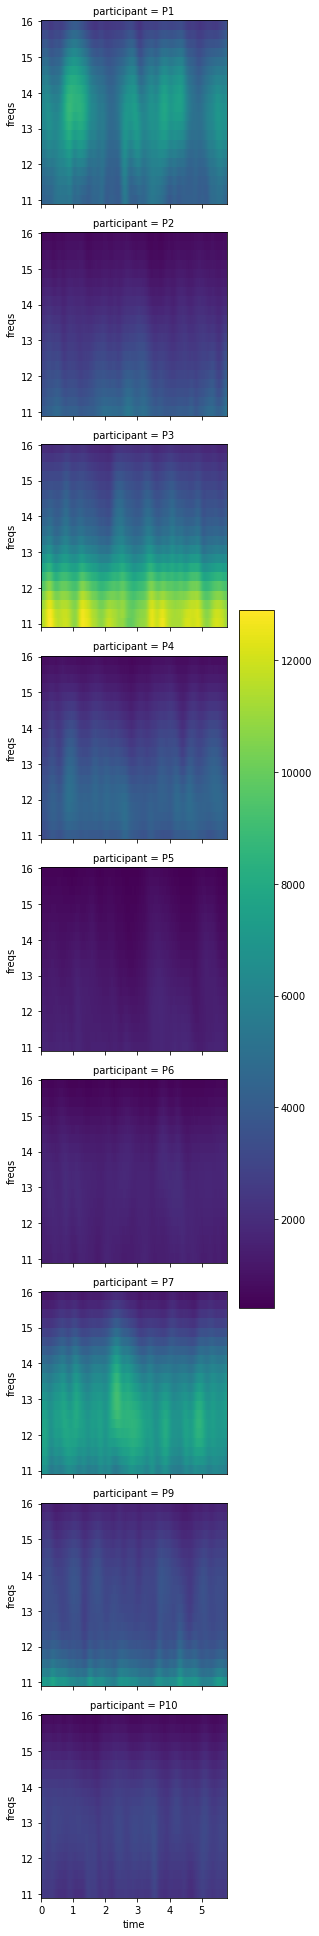

In [25]:
da_erp.mean('cycle').loc['raw',:,'e-i',11:16,:].plot.pcolormesh(x='time', row ='participant')

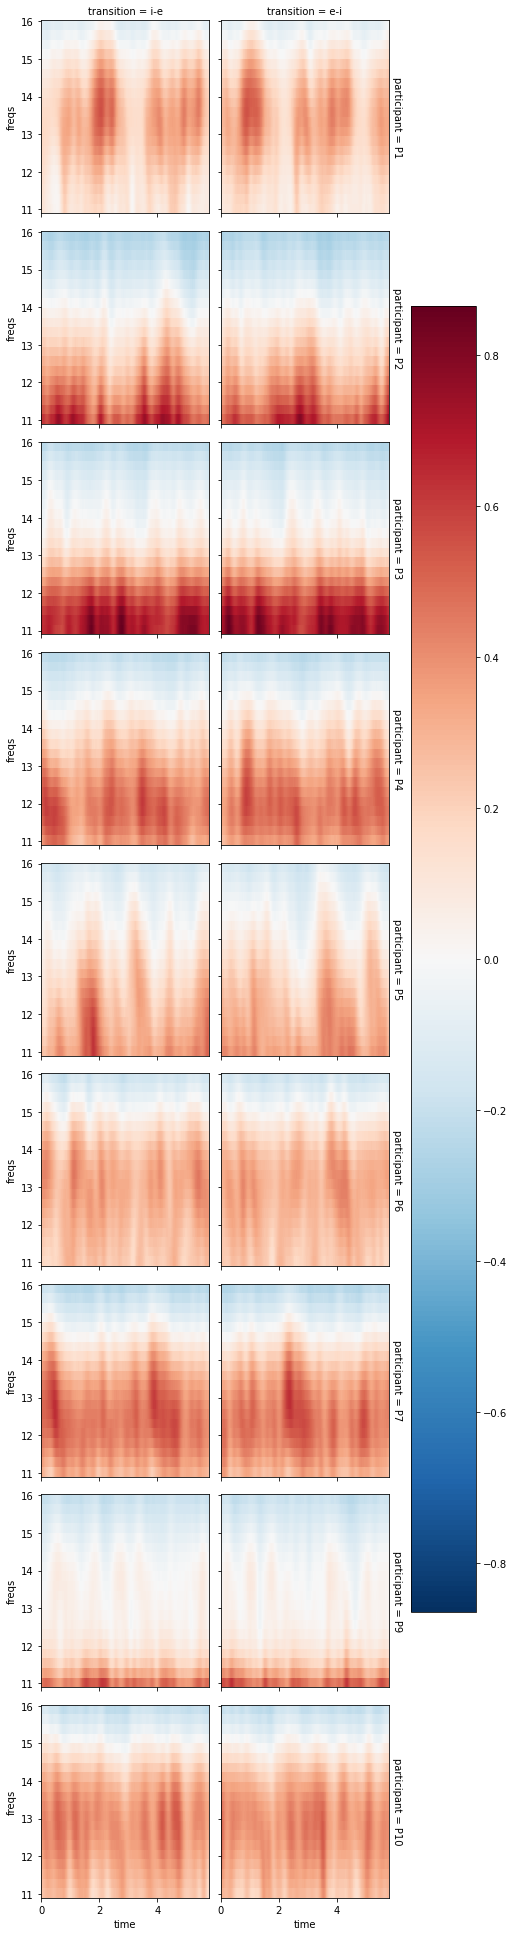

In [26]:
da_erp.mean('cycle').loc['normal',:,:,11:16,:].plot.pcolormesh(x='time', col = 'transition', row ='participant')

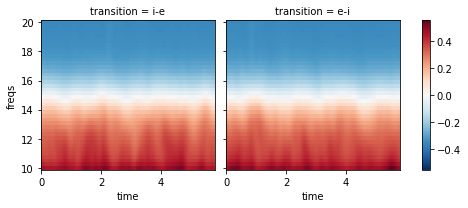

In [27]:
da_erp.mean(['participant','cycle']).loc['normal',:,:,:].plot.pcolormesh(x='time', col = 'transition')

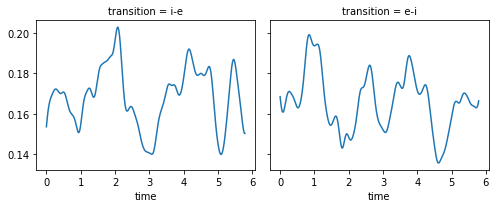

In [28]:
da_erp.mean(['participant','cycle']).loc['normal',:,11:16,:].mean('freqs').plot.line(x='time', col = 'transition')

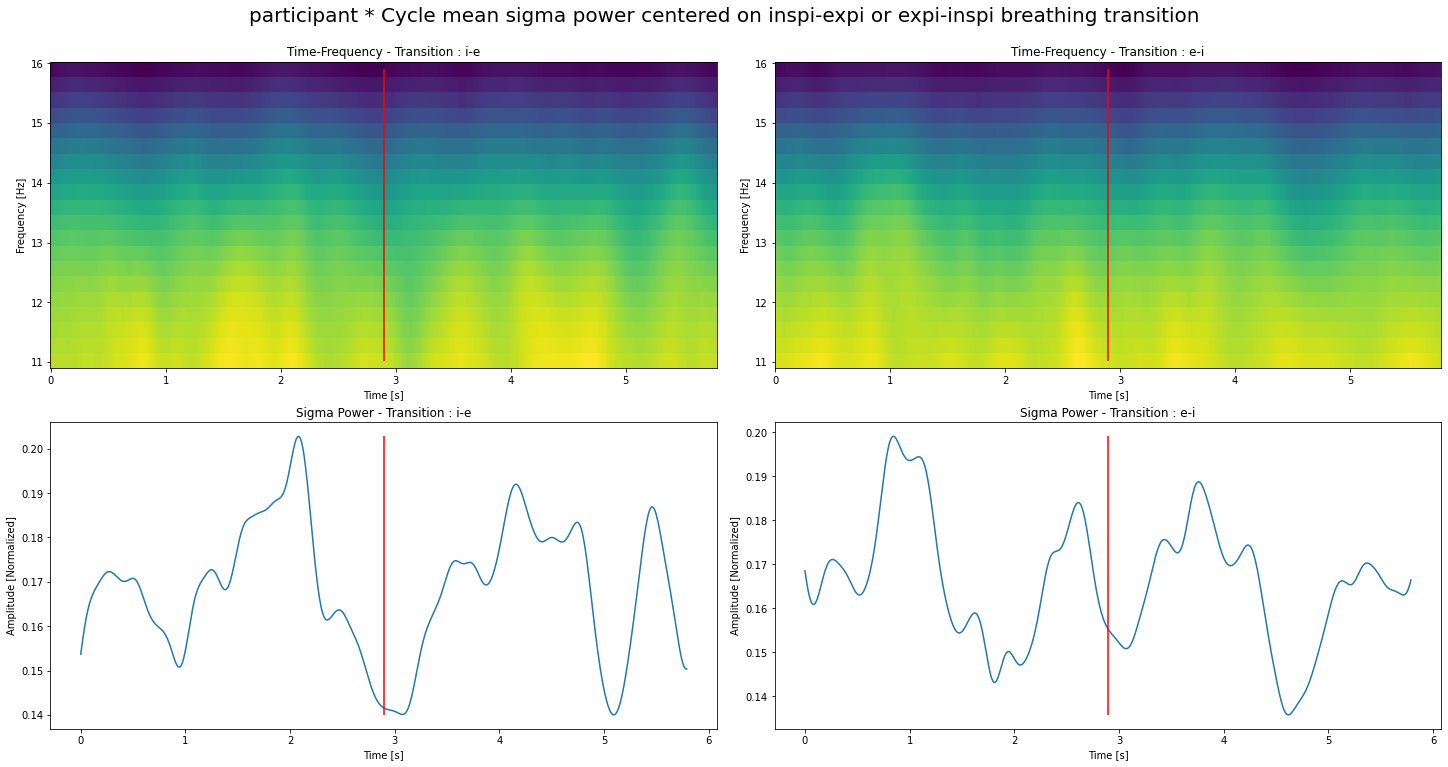

In [29]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10), constrained_layout = True)
fig.suptitle('participant * Cycle mean sigma power centered on inspi-expi or expi-inspi breathing transition', fontsize = 20, y = 1.05)

da_to_plot = da_erp.mean(['participant','cycle']).loc['normal',:,11:16,:]

for row, plot_mode in enumerate(['colormesh', 'line']):
    for col, transition in enumerate(da_to_plot.coords['transition'].values):

        ax = axs[row, col]
        t = da_to_plot.coords['time'].values
        f = da_to_plot.coords['freqs'].values
        data = da_to_plot.loc[transition,:].values

        if plot_mode == 'colormesh':
            ax.pcolormesh(t,f, data)
            ax.vlines(x=t[-1] / 2, ymin = min(f), ymax = max(f), color = 'r')
            ax.set_ylabel('Frequency [Hz]')
            ax.set_title(f'Time-Frequency - Transition : {transition}')

        elif plot_mode == 'line':
            ax.plot(t, np.mean(data, axis = 0))
            ax.vlines(x=t[-1] / 2, ymin = min(np.mean(data, axis = 0)), ymax = max(np.mean(data, axis = 0)), color = 'r')
            ax.set_ylabel('Amplitude [Normalized]')
            ax.set_title(f'Sigma Power - Transition : {transition}')

        ax.set_xlabel('Time [s]')
        
# plt.savefig('../presentation_5/erp_transition', bbox_inches = 'tight')

In [30]:
rsp.describe()

,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,event
count,3.243000e+04,3.243000e+04,32430.000000,32430.000000,32430.000000,32430.000000,32430.000000,32430.000000
mean,1.823512e+06,1.823872e+06,7123.094955,7124.499067,3.882672,1.404113,2.478559,0.305273
std,1.119161e+06,1.119167e+06,4371.724576,4371.745678,0.729301,0.322582,0.598275,0.460530
min,1.550000e+02,4.340000e+02,0.605469,1.695312,1.847656,0.503906,0.917969,0.000000
25%,8.584430e+05,8.588360e+05,3353.292969,3354.828125,3.402344,1.195312,2.058594,0.000000
50%,1.775516e+06,1.775835e+06,6935.607422,6936.855469,3.843750,1.410156,2.394531,0.000000
75%,2.678237e+06,2.678570e+06,10461.864258,10463.163086,4.273438,1.562500,2.820312,1.000000
max,4.752196e+06,4.752377e+06,18563.265625,18563.972656,13.281250,9.824219,9.847656,1.000000


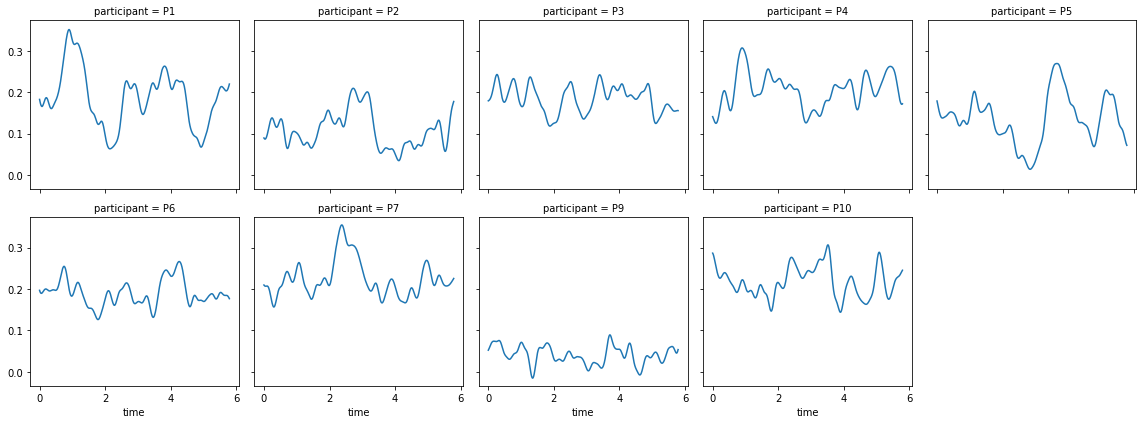

In [31]:
da_erp.mean(['cycle']).loc['normal',:,'e-i',11:16,:].mean('freqs').plot.line(x='time', col = 'participant', col_wrap = 5)
# plt.savefig('../presentation_3/erp_sigma_linepower_participants')

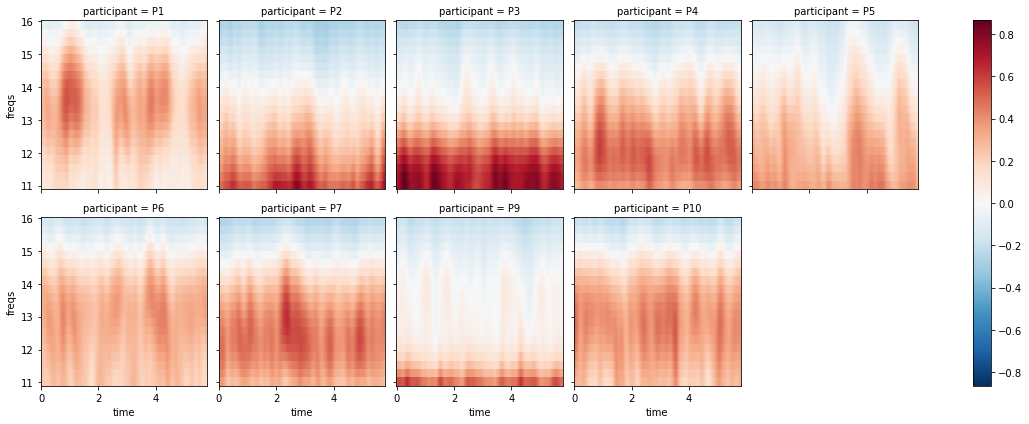

In [34]:
da_erp.mean(['cycle']).loc['normal',:,'e-i',11:16,:].plot.pcolormesh(x='time', col = 'participant', col_wrap = 5)
# plt.savefig('../presentation_5/erp_sigmapower_participants')